## Домашнее задание: Автокодировщик

## Цель:
### Узнать, как работает автокодировщик и что содержится в латентном представлении данных.

### Описание выполнения ДЗ:
- Обучить многослойный автокодировщик:
- Отрисовать классы в латентном представлении автокодировщика с двумерным латентным слоем
- Сделать tSNE над 32-мерным латентным слоем, отрисовать представление

### Обучить шумный автокодировщик:
- Добавить ко входным данным нормальный шум
- Сделать отражение части изображения
- Отрисовать карты активаций нейронов первого слоя

In [72]:
import torch
import torch.nn as nn
import numpy as np
import random
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
torch.utils.data.DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 32x32 colour images in 10 

#try VAE
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1 Многослойный автоэнкодер

## 1.1 Загрузка и подготовка данных

In [52]:
# Загрузка данных и создание dataloader
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataset = datasets.CIFAR10(root='./data', train=False,download=True,transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)

## 1.2 Архитектура модели:

In [44]:
# Простой автоэнкодер
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Autoencoder, self).__init__()
        
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        # Создание скрытого представления
        self.latent = nn.Linear(128*4*4, latent_dim)
        
        # Декодер
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (128,4,4)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        z = self.latent(x)
        x = self.decoder(z)
        return x, z

## 1.3 Обучение модели

In [45]:
# Определение модели
model = Autoencoder(latent_dim=2).to(device)

In [46]:
# Обучение
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(10):
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon, z = model(data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.0394369475543499
Epoch 2, Loss: 0.03587247431278229
Epoch 3, Loss: 0.03918486833572388
Epoch 4, Loss: 0.03860992193222046
Epoch 5, Loss: 0.03861425444483757
Epoch 6, Loss: 0.034405048936605453
Epoch 7, Loss: 0.03408133238554001
Epoch 8, Loss: 0.03276653587818146
Epoch 9, Loss: 0.03453541919589043
Epoch 10, Loss: 0.03449011594057083


## 1.4 Визуализация латентного пространства

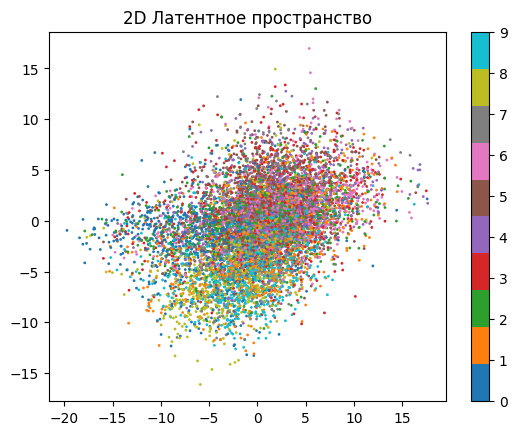

In [47]:
model.eval()
all_z = []
all_labels = []
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        recon, z = model(data)
        all_z.append(z.cpu())
        all_labels.append(labels)
all_z = torch.cat(all_z).numpy()
all_labels = torch.cat(all_labels).numpy()

plt.scatter(all_z[:,0], all_z[:,1], c=all_labels, cmap='tab10', s=1)
plt.colorbar()
plt.title('2D Латентное пространство')
plt.show()

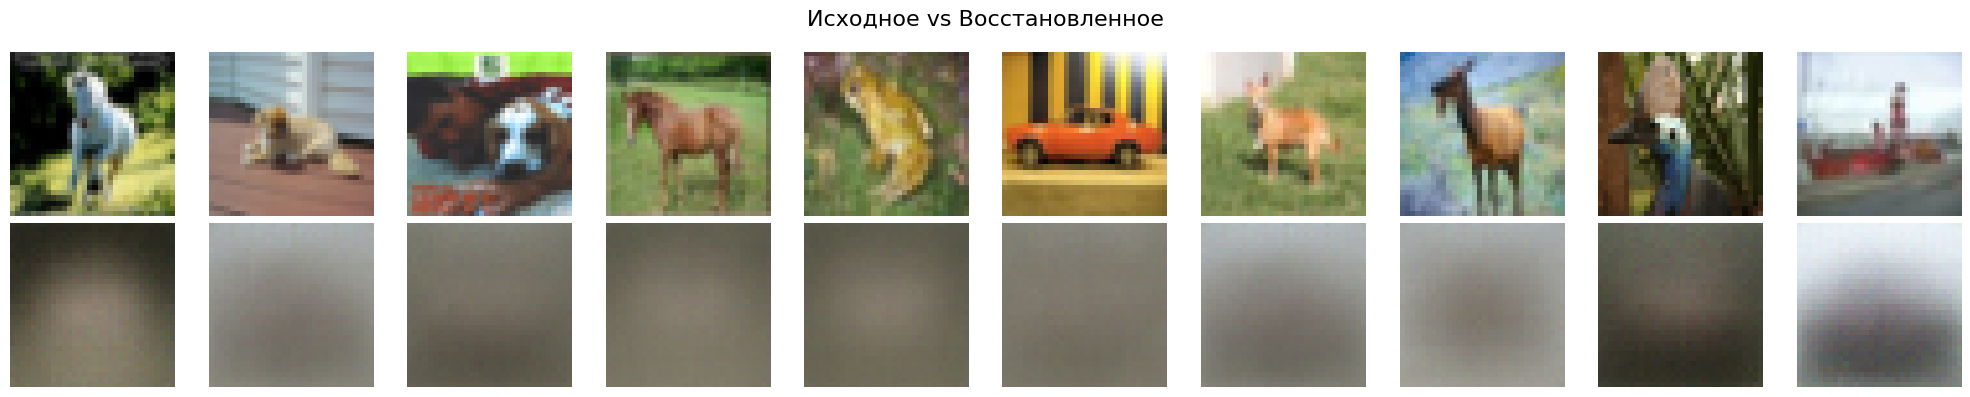

In [108]:
def reconstructions(model, data, n=10):

    model.eval()
    with torch.no_grad():
        recon, _ = model(data)  # Реконструкция
    
    # Создаем график
    fig, axes = plt.subplots(2, n, figsize=(20, 4))
    plt.suptitle('Исходное vs Восстановленное', fontsize=16)
    
    for i in range(n):
        # Оригинальное изображение
        img = data[i].cpu().permute(1, 2, 0).numpy()
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        
        # Восстановленное изображение
        rec = recon[i].cpu().permute(1, 2, 0).numpy()
        axes[1, i].imshow(rec)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

data, _ = next(iter(test_loader))
reconstructions(model, data, n=10)

# 2. t-SNE для 32-мерного латентного пространства

## 2.1 Обучение автоэнкодера с latent_dim=32:

In [10]:
model_32 = Autoencoder(latent_dim=32).to(device)
optimizer = torch.optim.Adam(model_32.parameters(), lr=0.001)

for epoch in range(10):
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon, z = model_32(data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.019819680601358414
Epoch 2, Loss: 0.01677950844168663
Epoch 3, Loss: 0.015537823550403118
Epoch 4, Loss: 0.012815878726541996
Epoch 5, Loss: 0.01298798993229866
Epoch 6, Loss: 0.013503818772733212
Epoch 7, Loss: 0.013388896360993385
Epoch 8, Loss: 0.01319580152630806
Epoch 9, Loss: 0.012806604616343975
Epoch 10, Loss: 0.011738256551325321


## 2.2 Применение t-SNE:

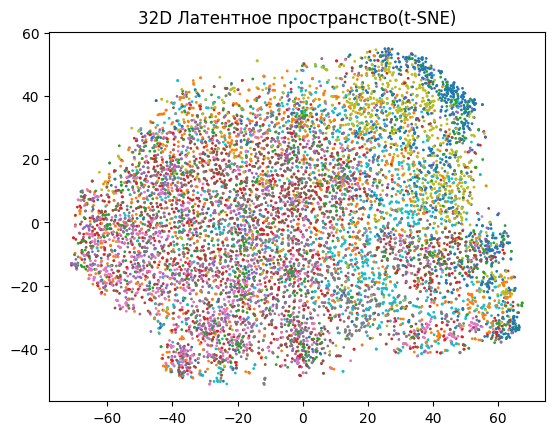

In [11]:
model_32.eval()
all_z_32 = []
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon, z = model_32(data)
        all_z_32.append(z.cpu())
all_z_32 = torch.cat(all_z_32).numpy()

tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(all_z_32)

plt.scatter(z_2d[:,0], z_2d[:,1], c=all_labels, cmap='tab10', s=1)
plt.title('32D Латентное пространство(t-SNE)')
plt.show()

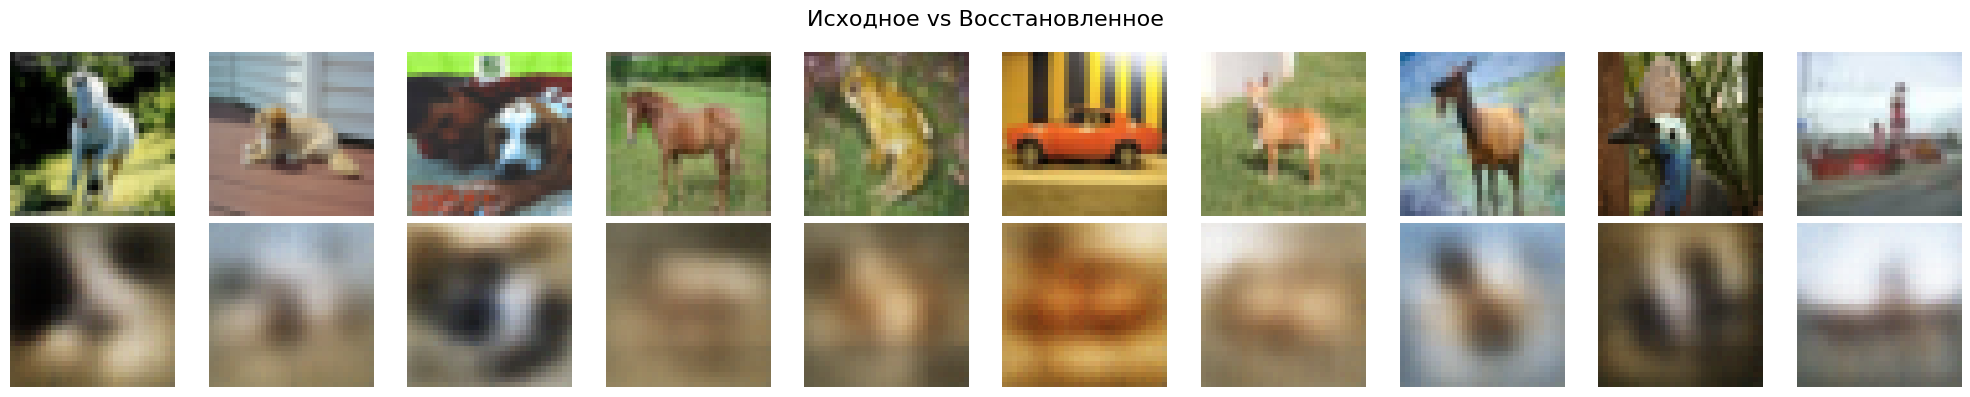

In [109]:
reconstructions(model_32, data, n=10)

# 3. Шумный автоэнкодер

## 3.1 Создание зашумленного датасета

In [73]:
class NoisyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, noise_std=0.2, flip_prob=0.5):
        super().__init__()
        self.dataset = dataset
        self.noise_std = noise_std
        self.flip_prob = flip_prob

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        # Добавление шума
        noisy_image = image + self.noise_std * torch.randn_like(image)

        # Отражение половины изображения
        if torch.rand(1) < self.flip_prob:
            width = image.shape[2]
            
            # Случайная сторона
            flip_side = random.choice(['left', 'right'])
            
            if flip_side == 'left':
                half = noisy_image[:, :, :width//2]
                flipped_half = torch.flip(half, dims=[2])
                noisy_image[:, :, width//2:] = flipped_half
            else:
                half = noisy_image[:, :, width//2:]
                flipped_half = torch.flip(half, dims=[2])
                noisy_image[:, :, :width//2] = flipped_half

        return noisy_image, image

noisy_train_dataset = NoisyDataset(train_dataset, noise_std=0.1, flip_prob=0.5)
noisy_train_loader = torch.utils.data.DataLoader(noisy_train_dataset, batch_size=256, shuffle=True)

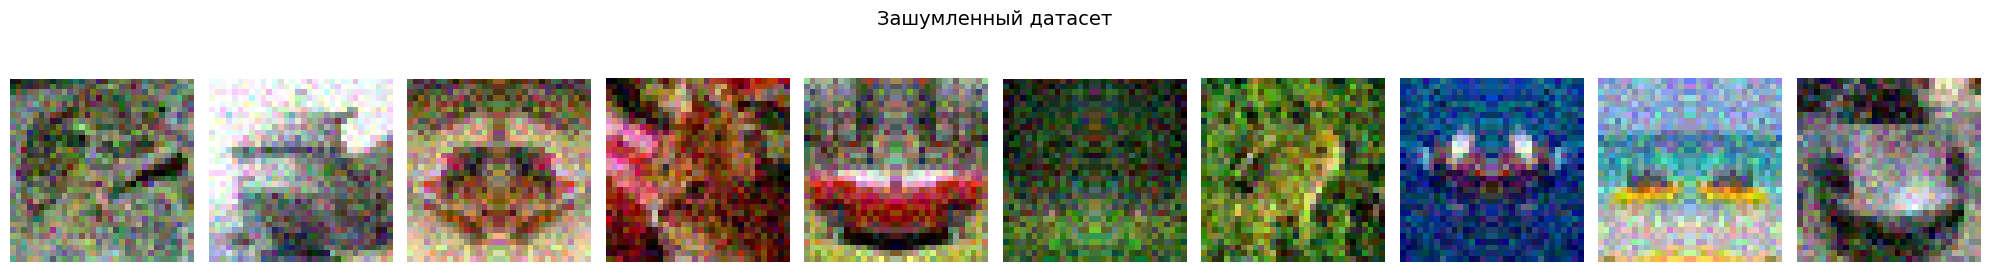

In [110]:
def show_noisy(noisy_loader, n=10):
    noisy_images, _ = next(iter(noisy_loader)) 
    noisy_images = noisy_images[:n].cpu()

    def to_image(img):
        img = img.permute(1, 2, 0).numpy()
        return np.clip(img, 0, 1)

    fig, axes = plt.subplots(1, n, figsize=(20, 3))
    plt.suptitle("Зашумленный датасет", fontsize=14)

    for i in range(n):
        # Зашумленное изображение
        noisy_img = to_image(noisy_images[i])
        axes[i].imshow(noisy_img)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_noisy(noisy_train_loader, n=10)

## 3.2 Обучение шумного автоэнкодера

In [100]:
model_noisy = Autoencoder(latent_dim=32).to(device)
optimizer = torch.optim.Adam(model_noisy.parameters(), lr=0.0001)

for epoch in range(10):
    for noisy_data, clean_data in noisy_train_loader:
        noisy_data = noisy_data.to(device)
        clean_data = clean_data.to(device)
        optimizer.zero_grad()
        recon, z = model_noisy(noisy_data)
        loss = criterion(recon, clean_data)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.032226018607616425
Epoch 2, Loss: 0.028280163183808327
Epoch 3, Loss: 0.02870994247496128
Epoch 4, Loss: 0.028223847970366478
Epoch 5, Loss: 0.02721431665122509
Epoch 6, Loss: 0.026908989995718002
Epoch 7, Loss: 0.028216788545250893
Epoch 8, Loss: 0.020177705213427544
Epoch 9, Loss: 0.02301761507987976
Epoch 10, Loss: 0.024325916543602943


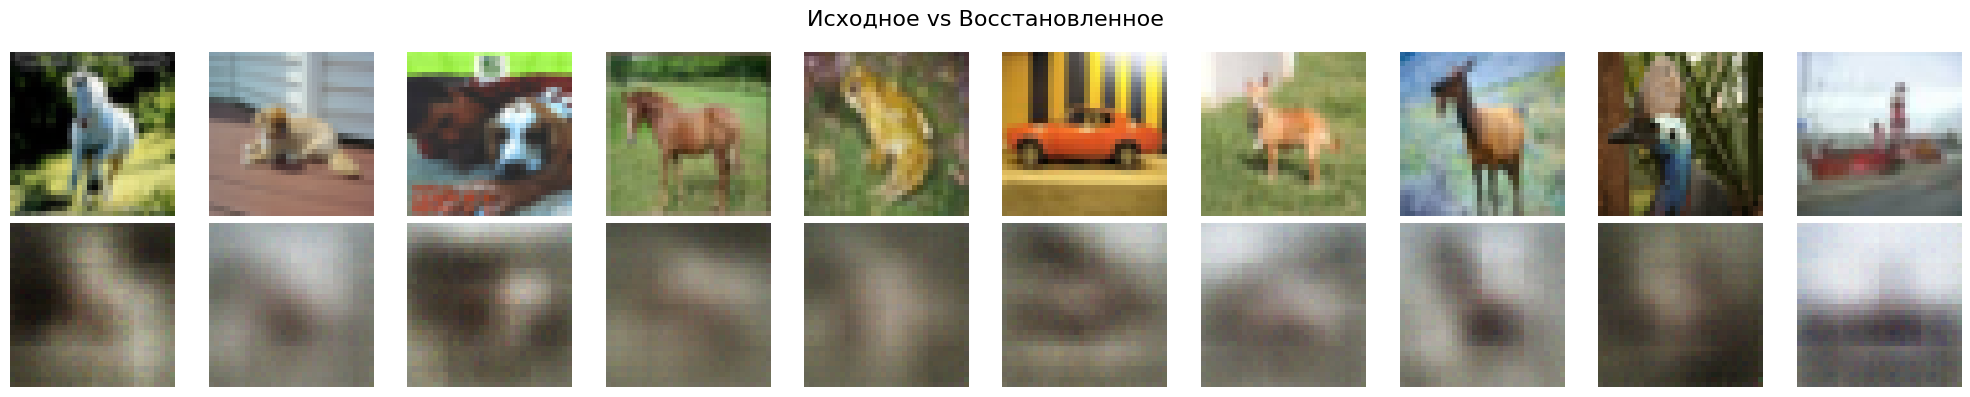

In [114]:
reconstructions(model_noisy, data, n=10)

## 3.3 Визуализация карт активаций

In [98]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach().cpu()
    return hook

# Регистрация
model_noisy.encoder[0].register_forward_hook(get_activation('conv1'))

data, _ = test_dataset[0]  # Одно изображение
data = data.unsqueeze(0).to(device)

model_noisy.eval()
with torch.no_grad():
    recon, _ = model_noisy(data)  # Прогоняем через модель

# Активации
act = activation['conv1']

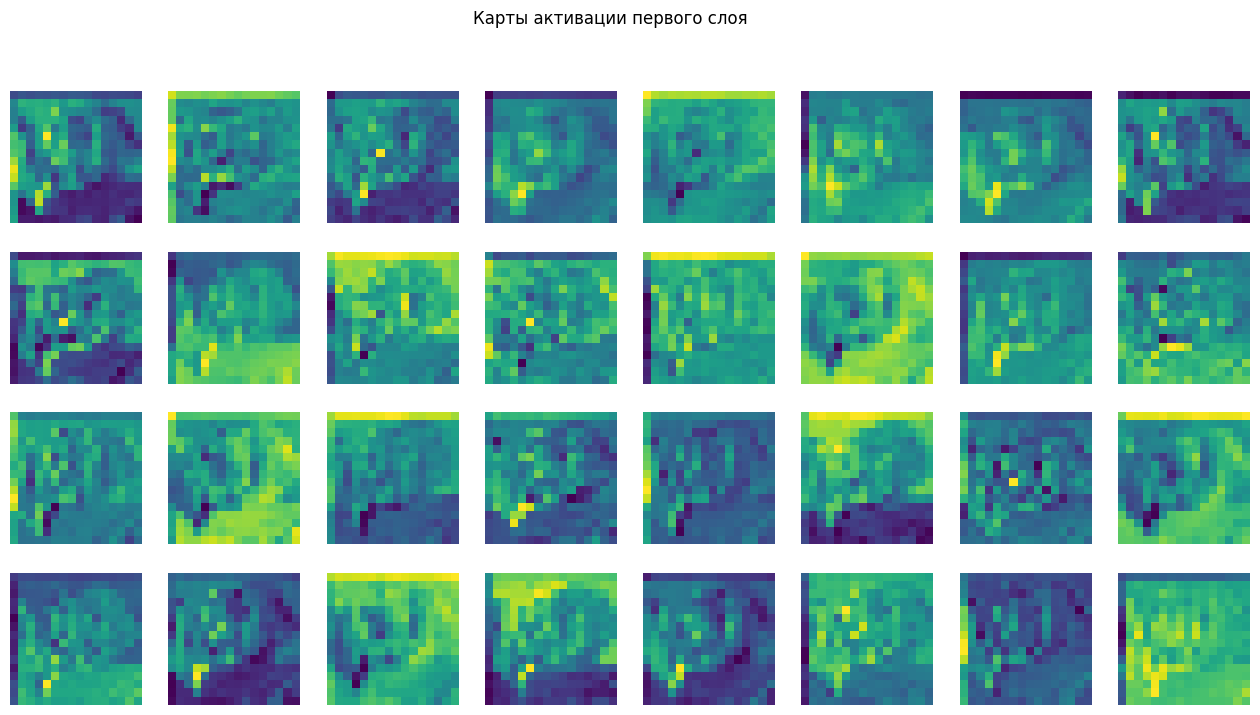

In [99]:
act = act[0] 
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    if i < act.shape[0]:
        ax.imshow(act[i])
        ax.axis('off')
plt.suptitle('Карты активации первого слоя')
plt.show()

Вывод:
1) Была взята "игрушечная" модель автоэнкодера. Сжали данные автоэнкодером и представили их на плоскости разделив на классы. Четких кластеры пактически не прослеживаются, в основном пересечения - модель слабая для разделения классов. Реконструкция изображения подтверждает это.
2) При попытке визуализировать многомерное пространство с помощью tSNE, кластеры лучше прослеживаются из чего вытекает что в многомерном пространстве модель лучше фиксирует особенности в данных. Реконструкция изображения подтверждает это.
3) После обучения на измененных данных, при реконструкции изображения модель показывает что может выделять признаки и восстанавливать изобаржение(по крайней мере структуру), но в силу слабой архетектуры не удалось увидеть как автоэнкодер игнорирует случайный шум.
4) На текущем этапе обучения CV, визуализацию значений первого слоя, мне, сложно интерпретировать в пелезную информацию по типу объяснения поведения модели(вижу каракульки, не исключаю слабую модель).